In [1]:
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#PGD code adapted from https://github.com/Harry24k/adversarial-attacks-pytorch

class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std


norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
weights = ResNet50_Weights.DEFAULT

model = nn.Sequential(
    norm_layer,
    resnet50(weights=weights))


model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

model = model.eval()



torch.Size([3, 2501, 2501]) torch.Size([1, 3, 224, 224])


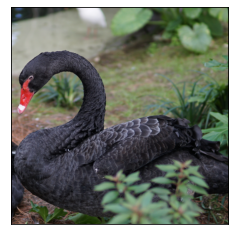

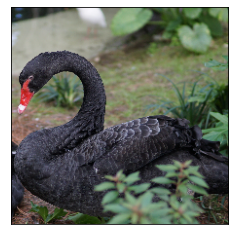

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transform = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(mean=[0, 0, 0], std=[255.0, 255.0, 255.0]),
    
])

        
img = read_image('images/black_swan.jpeg')
#img = read_image('images/macaw.jpg')
show([img])
batch = transform(img.float()).unsqueeze(0)
print(img.shape,batch.shape)
show(batch)

In [3]:
batch = batch.to(device)
prediction = model(batch).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print("Original Label: "f"{category_name} {100 * score:.1f}%")
print("Top-K labels:",prediction.topk(5)[1].cpu().numpy())


Original Label: black swan 47.5%
Top-K labels: [100 146  99  22  80]


In [4]:
def PGD(model, x, y, loss_fn, num_steps, step_size, step_norm, eps, eps_norm,
                               clamp=(0,1), y_target=None):

    x_adv = x.clone().detach().requires_grad_(True).to(x.device)
    targeted = y_target is not None
    num_channels = x.shape[1]

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)

        prediction = model(_x_adv)
        loss = loss_fn(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            if step_norm == 'inf':
                gradients = _x_adv.grad.sign() * step_size
            else:
                # Note .view() assumes batched image data as 4D tensor
                gradients = _x_adv.grad * step_size / _x_adv.grad.view(_x_adv.shape[0], -1)\
                    .norm(step_norm, dim=-1)\
                    .view(-1, 1, 1, 1)

            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
                x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1)
            scaling_factor[mask] = eps

            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, 1, 1, 1)

            x_adv = x + delta
            
        x_adv = x_adv.clamp(*clamp)
    
    delta = x_adv-x
    return x_adv.detach(), delta 


In [5]:
num_steps = 100
eps = 8/255.0
step_size = 2.5*eps*0.01 
step_norm = 'inf'
eps_norm = 'inf'
#step_norm = 2
#eps_norm = 2




target = nn.functional.one_hot(torch.tensor(987), num_classes=1000).unsqueeze(0).float().to(device)
criterion = nn.CrossEntropyLoss()
perturbed_data, delta = PGD(model, batch, torch.tensor([class_id]).to(device), criterion, num_steps, step_size, step_norm, eps, eps_norm,clamp=(0,1),y_target=target)

In [6]:
prediction = model(perturbed_data).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print("Attacked Label: "f"{category_name} {100 * score:.1f}%")

Attacked Label: corn 100.0%


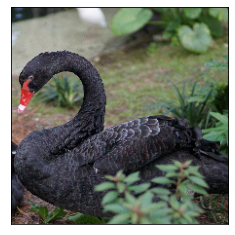

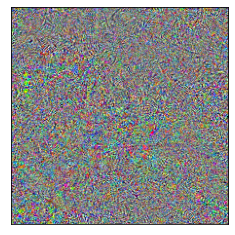

In [7]:
show(perturbed_data)
a = delta.min().cpu().detach()
b = delta.max().cpu().detach()
scaledDelta = (delta-a)/(b-a)
show(scaledDelta)